# Effects of biological variability and measurement noise on classification performance

A demo which analyzes how the classification performance is affected by varying biological variability and measurement noise.
Cohorts are created at different levels of biological variability and measurement noise using the _generate_spectra_ function. Each cohort is then cross-validated upon to calculate the area under the ROC curve of the classification.
The Sci-kit learn package is used for the machine learning analysis.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from spectral_generator import generate_spectra

## Loading input data 

Spectral data is used for calibrating the model. Data from the lung cancer vs. non-symptomatic controls is used for this demo. Water measurement are loaded in as well to calculate the measurement noise.

### Blood serum spectra

In [2]:
serum_spectra = pd.concat((pd.read_csv('data/dataset_1_part_%s.csv' % f.zfill(2)) for f in np.arange(1, 21).astype(str)), ignore_index=True) # load the cancer and non-cancer spectra from file

In [3]:
X = serum_spectra.iloc[0:100000, 1:] # matrix containing the spectra of lung cancer and control samples. samples in rows, wavenumers in columns.
X.columns = X.columns.astype(float)

y = serum_spectra.iloc[0:100000, 0] # vector containing the sample labels.
y = y.replace({'lung cancer control': 0, 'lung cancer case': 1})

### Water spectra

In [4]:
water_spectra = pd.read_csv('data/dataset_2.csv') # load the mean-subtracted water spectra from file.
water_spectra.columns = water_spectra.columns.astype(float)

## Defining the calibration parameters

Parameters are calculated from the input data and will be given as inputs to the _spectral_generator_ function.

### Calculating the biological properties

In [5]:
mu_neg = X[y==0].mean(axis=0) # mean spectrum of control samples.
mu_pos = X[y==1].mean(axis=0) # mean spectrum of case samples.

B_neg = X[y==0] - mu_neg # calibration vectors for control samples.
B_pos = X[y==1] - mu_pos # calibration vectors for case samples.

d = mu_pos - mu_neg # discriminant vector, defining the difference in mean between cases and controls.

### Calculating the measurement noise

In [6]:
epsilon_std = water_spectra.std(axis=0) # standard deviation across the spectral features of the water measurements
epsilon_std *= 9.15 # scaling factor, to account for the l2 vector normalization in the preprocessing of the sera measurements

## Classification pipeline

An L2-regularized logistic regression binary classifier is used.
Model performance is estimated in a 10 fold cross-validation on standardized features.
The regularization strength of the logistic regression is tuned in an inner 3 fold cross-validation on each training split of the outer cross-validation.

In [7]:
cv_3  = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clf = LogisticRegression(penalty='l2', tol=1e-2, max_iter=100000)

pipeline = Pipeline([('scale', StandardScaler(with_mean=True, with_std=True)),
                     ('clf', clf)])

estimator = GridSearchCV(estimator=pipeline, 
                         param_grid={'clf__C': 2. ** np.arange(-12, 15, 3)},
                         cv=cv_3, scoring='roc_auc', n_jobs=1, 
                         error_score='raise', verbose=0)

## Effects of biological variability and measurement noise

A set of different biological variability and measurement noise factors are tested. The calibrated variability parameters of the model are scaled by factors and multiple cohorts are generated for each combination. Classification performance is then assessed in a 10-fold cross-validation on each generated cohort. A classification model is fit and the area under the ROC curve (ROC-AUC) gets calculated for each cross-validation split. ROC-AUC values are then averaged across all folds for a given parameter combination.

In [8]:
# set the biological variability factors. 
# each factor will scale the biological variability e.g. 2 times higher than the calibrated level.
beta_scalars = [0, 0.5, 1, 1.5, 2, 2.5]

# set the measurement noise factors. 
# each factor will scale the measurement noise e.g. 2 times higher than the calibrated level.
epsilon_scalars = [0, 2, 4, 6, 8, 10]

# set the sample size for cases (pos) and controls (neg).
n_pos = n_neg = 523

# set the calibrated level of biological variability for cases and controls.
beta_std_neg = 1/np.sqrt(B_neg.shape[0])
beta_std_pos = 1/np.sqrt(B_pos.shape[0])

# set the number of times to repeat the cross-validation using each beta_scalar and epsilon_scalar combination.
# different cohorts will be created in each repetition.
# the higher the number, the more robust the classification performance estimation is (especially for smaller sample sizes).
n_repeats = 10

In [9]:
results = [] # list to store the classification result of each parameter combination.
random_state = 0 # random state to be incremented such that each generated cohort is based on a different random seed.

i = 0
for beta_scalar in beta_scalars:
    for epsilon_scalar in epsilon_scalars:
        start = time.time() # to monitor how much time is taken in each loop iteration.
        i += 1
        print('Iter %d/%d:' % (i, len(beta_scalars) * len(epsilon_scalars)), end='\t')

        roc_aucs_train = [] # list to store the calculated roc_aucs for the training sets for all repetitions and CV splits.
        roc_aucs_test = [] # list to store the calculated roc_aucs for the testing sets for all repetitions and CV splits.
        for j in range(n_repeats):
            random_state += 1
            X_gen, y_gen = generate_spectra(B_neg=B_neg, B_pos=B_pos, 
                                            mu_neg=mu_neg, mu_pos=mu_pos, 
                                            n_neg=n_neg, n_pos=n_pos,
                                            beta_std_neg=beta_scalar*beta_std_neg, beta_std_pos=beta_scalar*beta_std_pos, # scale the biological variability. 
                                            epsilon_std=epsilon_scalar*epsilon_std, # scale the technical noise.
                                            random_state=random_state)
            
            scores = cross_validate(estimator=estimator,
                                    X=X_gen, y=y_gen, # use the generated cohort as the input to the cv.
                                    cv=cv_10, 
                                    scoring='roc_auc',
                                    verbose=0, 
                                    n_jobs=-1, # using all cores available to evaluate the cv splits in parallel.
                                    return_train_score=True,
                                    error_score='raise')

            roc_aucs_train.extend(scores['train_score'])
            roc_aucs_test.extend(scores['test_score'])

        # append the result for the current parameter combination.
        results.append({
            'epsilon_scalar': epsilon_scalar, 
            'beta_scalar': beta_scalar, 
            'cv_roc_auc_mean_train': np.mean(roc_aucs_train),
            'cv_roc_auc_std_train': np.std(roc_aucs_train),
            'cv_roc_auc_mean_test': np.mean(roc_aucs_test),
            'cv_roc_auc_std_test': np.std(roc_aucs_test),
        })

        print('beta_scalar=%.1f' % results[-1]['beta_scalar'], end=', ')
        print('epsilon_scalar=%.1f' % results[-1]['epsilon_scalar'], end=', ')
        print('roc_auc_train=%.2f ± %.2f' % (results[-1]['cv_roc_auc_mean_train'], results[-1]['cv_roc_auc_std_train']), end=', ')
        print('roc_auc_test=%.2f ± %.2f' % (results[-1]['cv_roc_auc_mean_test'], results[-1]['cv_roc_auc_std_test']), end=', ')
        print('elpsd %ds' % int(time.time()-start))

Iter 1/36:	beta_scalar=0.0, epsilon_scalar=0.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 23s
Iter 2/36:	beta_scalar=0.0, epsilon_scalar=2.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 21s
Iter 3/36:	beta_scalar=0.0, epsilon_scalar=4.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 22s
Iter 4/36:	beta_scalar=0.0, epsilon_scalar=6.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 22s
Iter 5/36:	beta_scalar=0.0, epsilon_scalar=8.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 22s
Iter 6/36:	beta_scalar=0.0, epsilon_scalar=10.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 22s
Iter 7/36:	beta_scalar=0.5, epsilon_scalar=0.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=0.99 ± 0.01, elpsd 105s
Iter 8/36:	beta_scalar=0.5, epsilon_scalar=2.0, roc_auc_train=1.00 ± 0.00, roc_auc_test=0.97 ± 0.01, elpsd 73s
Iter 9/36:	beta_scalar=0.5, epsilon_scalar=4.0, roc_auc_train=0.99 ± 0.01, roc_auc_test=0.96 ± 0.02, elpsd 56s

## Display results

In [10]:
df_results = pd.DataFrame(results)
display(df_results)

,epsilon_scalar,beta_scalar,cv_roc_auc_mean_train,cv_roc_auc_std_train,cv_roc_auc_mean_test,cv_roc_auc_std_test
0,0,0.0,1.000000,0.000000,1.000000,0.000000
1,2,0.0,1.000000,0.000000,1.000000,0.000000
2,4,0.0,1.000000,0.000000,1.000000,0.000000
3,6,0.0,1.000000,0.000000,1.000000,0.000000
4,8,0.0,1.000000,0.000000,1.000000,0.000000
5,10,0.0,1.000000,0.000000,1.000000,0.000000
6,0,0.5,0.999983,0.000063,0.987341,0.008735
7,2,0.5,0.997396,0.004537,0.970472,0.014164
8,4,0.5,0.990519,0.008871,0.959867,0.017770
9,6,0.5,0.985038,0.008268,0.957052,0.018731


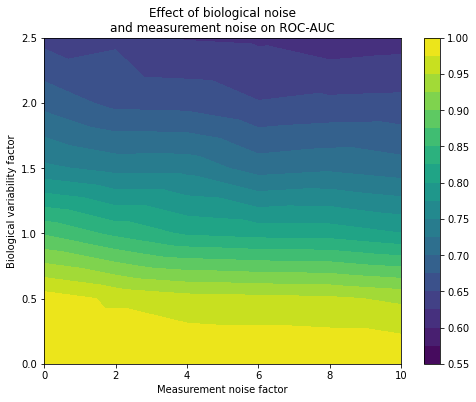

In [11]:
plt.figure(figsize=(8, 6))
plt.title('Effect of biological noise\nand measurement noise on ROC-AUC')
plt.tricontourf(df_results['epsilon_scalar'],
                df_results['beta_scalar'], 
                df_results['cv_roc_auc_mean_test'],
                levels=np.arange(0.55, 1.01, 0.025),
                extend='neither')
plt.colorbar()
plt.xlabel('Measurement noise factor')
plt.ylabel('Biological variability factor')
plt.show()